# Análise de sentimento - Comentários de Análises de Celulares no Youtube

In [145]:
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder

import numpy
from scikitplot.metrics import plot_confusion_matrix
 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

In [146]:
comments_site_analysis = pd.read_csv('src/comments_site_analysis.csv')

In [147]:
phones_colleted = pd.read_csv("src/phones_colleted.csv")

In [148]:
#default transformation
df = pd.read_csv('src/video_comments_final_types2.csv')
df['comment'] = df['comment'].astype(str)
df['final_type'] = df['final_type'].astype(int)

# 1 Exposição do problema

Observando o volume de análises de celulares eletrônicos no youtube e sua popularidade de comentários, notei a possibilidade de efetuar uma categorização dos comentários desses vídeos a fim de conseguir uma indicação sobre quais os celulares são mais bem ou mal recebidos pelo público. Trazendo uma expectativa popular sobre os mesmos. 

Temos assim como objetivo do modelo indicar quais são os comentários negativos e positivos das análises dos celulares, ou seja, seu valor de recall para comentários negativos e positivos.

O maior desafio para este processo é a forma de categorizar a base principal dos dados para o treino do meu modelo. Os comentários dos vídeos do youtube possuem somente a opção “like” que não define se o mesmo é positivo ou negativo, somente se o comentário foi aceito pela maioria ou não. Algumas tentativas de utilização de APIs para definição desta base como o google natural language api foram utilizadas, porém com resultados bastante insatisfatórios. 


# 2 Coleta dos dados

## 2.1 Levantamento dos produtos eletônicos

Foi selecionado um total de 26 celulares para a análise com base nos lançamentos de 2020 e 2021 mais populares pelas suas faixas de preços. Coletei um total de 10 mil comentários para a base de dados. 

In [149]:
phones_colleted

,Celular,Faixa de preço até
0,Samsung Galaxy A10s,1000
1,Moto E7,1000
2,LG K22,1000
3,Xiaomi Redmi 9,1000
4,Philco Hit Max,1000
5,Motorola Moto G9 Power,2000
6,Samsung Galaxy M31,2000
7,Motorola One Fusion Plus,2000
8,Samsung Galaxy A71,2000
9,Poco X3 NFC,2000


## 2.2 Levantamento da pesquisa e filtro dos vídeos

Considerei que a melhor maneira de encontrar os reviews dos produtos é por meio da pesquisa com o título “ ‘marca + modelo’ análise" em português para vídeos enviados até 12 meses atrás e com no mínimo 50 mil visualizações. Espera-se que ao menos 5 vídeos de cada aparelho sejam analisados.

## 2.3 Coleta das informações

Como evidenciado na exposição do problema não tínhamos uma forma existente de coleta desses comentários já classificados no youtube. Para isso criou-se então um site de classificação dos comentários aberto ao público. O mesmo pode ser visualizado através do [link](https://comments-reviews-web-app.vercel.app/). A mesma tem a seguinte interface:

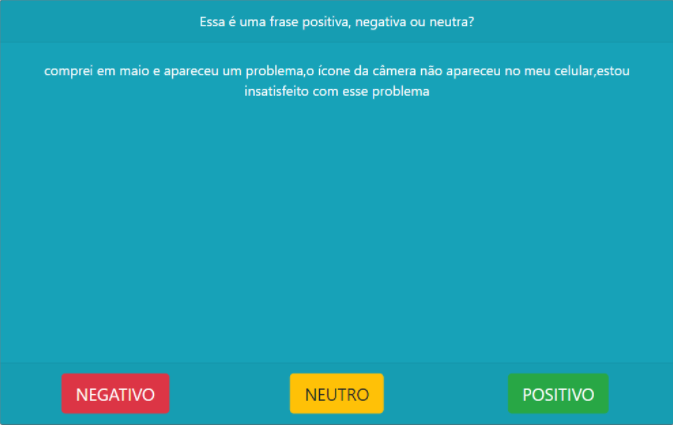

In [150]:
from IPython.display import display, Image
display(Image(filename='src/site_example.png'))

A interface contem os seguintes requisitos funcionais e técnicos:

### 2.3.1 Criada em Reactjs e os dados são armazenados por meio do Firebase;

### 2.3.2 A seleção dos comentários para os usuários foi de forma aleatória e com pesos. Onde os comentários menos avaliados pelos usuários tinham um peso maior para serem trazidos com maior probabilidade antes dos mais avaliados;

### 2.3.3 Cada usuário que fez a avaliação será diferenciado pelo IP ou um timestamp da página aberta no momento a fim de contabilizar o experimento;

### 2.3.4 Um total de 10 mil comentários foram armazenados na ferramenta.

# 3.1 Preparação dos dados

Após a criação do site para a coleta de avaliações, monitorei os dados coletados e avaliados pelos usuários. Meu número final de comentários avaliados foi o evidenciado abaixo: 

In [151]:
comments_site_analysis

,Unnamed: 0,data,comentarios avaliados,comentarios avaliados %,comentários com 2,comentários com 3,comentários com 1,comentários com 4,comentários com 5,comentários com 6,comentarios avaliados totais
0,0,06/09/2021 10:36:01,4908,49.08,1142,232,3491,35,7,1,6652


Com os comentários avaliados, efetuei então a coleta dos dados. Os detalhes do mesmo utilizando a API do firebase podem ser encontrados em "5.youtube-review-comment-collect.ipynb". O mesmo não será exposto aqui a fim de condensar o processo.

Após a coleta dos dados do Firebase e sua manipulação, os seguintes dados foram coletados:

In [152]:
df

,comments_id,comment-date,comment-author,comment,comment-likes,video-id,video-title,video-date,video-link,video-likes,video-views,video-channel,video-comment-count,final_type
0,0.UgwozCGH-HDyIES2ciF4AaABAg,2020-12-20T22:44:18Z,POP 0stras,Uma porcaria. Comprei faz 3 meses. Muito arrep...,0,jSv8fxe3_KU,"GALAXY NOTE 10 LITE, FAZ SENTIDO COMPRAR? [Han...",2020-02-19T16:00:09Z,https://www.youtube.com/watch?v=jSv8fxe3_KU,18773,307422,Canaltech,1013,-1
1,3.Ugzuo_fNCeU10B0Iqv54AaABAg,2021-04-19T01:28:56Z,tout a commencé en France,Assistindo com o meu a51 e agora estou querend...,10,6LwYbm71AJM,Review GALAXY S21 ULTRA! Agora sim a SAMSUNG f...,2021-04-07T22:00:01Z,https://www.youtube.com/watch?v=6LwYbm71AJM,5287,91701,Be!Tech,430,1
2,4.UgzaPxJpaltmYRPm7WZ4AaABAg,2021-06-03T22:58:59Z,Tasio de Luanda Luanda,Bom eu tenho problemas e com poeira água e queda,0,5JWFHfF4nGg,SAMSUNG GALAXY M31 // um INTERMEDIÁRIO com 600...,2020-07-09T21:19:36Z,https://www.youtube.com/watch?v=5JWFHfF4nGg,22040,304881,EscolhaSegura,1413,1
3,5.Ugxg7N1mhRETPeDd0jB4AaABAg,2021-03-04T02:37:38Z,ᴘ ʀ ɪ ɴ ᴄ ᴇ s ᴀッ™,Se no Samsung vier os emoji do iPhone eu me re...,0,vOVz5rPk2vU,GALAXY NOTE 10 e GALAXY NOTE 10 PLUS!,2019-08-07T23:00:51Z,https://www.youtube.com/watch?v=vOVz5rPk2vU,196838,2130935,Coisa de Nerd,5604,0
4,6.Ugwxvye3XUXp-6GdwxV4AaABAg,2021-03-03T20:09:55Z,Eu Mesmo,"Smartphone gamer muito excelentente msm, mas f...",0,TdALKXTVZRU,ROG PHONE 3: UNBOXING DO SMARTPHONE MAIS PODER...,2020-07-22T15:30:08Z,https://www.youtube.com/watch?v=TdALKXTVZRU,62254,942191,Loop Infinito,2266,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4902,9990.Ugz4MHAKLSZjySMHC8p4AaABAg,2020-10-22T19:19:10Z,Saulo Lima,"Entrada em cima , n gosto ! Gosto de entrada e...",0,uwlW-aTc5j4,MOTOROLA EDGE+! O MELHOR MOTOROLA JA FEITO! Ma...,2020-07-02T11:59:43Z,https://www.youtube.com/watch?v=uwlW-aTc5j4,11290,117110,Dudu Rocha,835,1
4903,9993.Ugy9hH2G4Nq55fBuJ414AaABAg,2020-12-06T20:06:26Z,Andressa Tenório,Sempre quis dizer isso.... assistindo do meu a...,1,w8ZokAmv8yE,Review Samsung Galaxy A71: um celular intermed...,2020-08-10T17:25:44Z,https://www.youtube.com/watch?v=w8ZokAmv8yE,15444,257622,TecMundo,1155,1
4904,9995.UgzCH5fbhBklPp22nbd4AaABAg,2021-06-29T03:21:41Z,XTRAJ4DO FF 🇧🇷,To doido pra ganhar o meu moto g9 play,0,kX2xqUDqfRA,Motorola Moto G9 Play vs Moto G9 Power - QUAL ...,2021-02-04T14:51:00Z,https://www.youtube.com/watch?v=kX2xqUDqfRA,20068,290832,Gesiel Taveira,1108,1
4905,9997.Ugwu1TjlQHr-soAyagt4AaABAg,2020-12-27T22:47:16Z,Gu,Mi 10t pro ou mi 10 pro?,0,MSqN27wR-gI,MI 10T PRO: TOP de LINHA XIAOMI com PREÇO de I...,2020-12-27T22:20:22Z,https://www.youtube.com/watch?v=MSqN27wR-gI,2286,65595,TudoCelular,430,0


Onde "final_type" corresponde a classificação do comentário positivo (1), neutro(0) ou negativo(-1)

# 3.2 Transformação com técnicas de NLP

Meu objetivo aqui é padronizar meus comentários a fim de aplicar as tecnicas de criação de feature (LSA e Word2Vec). Defini funções para cada uma das etapadas da transformação, as mesmas são:

### 3.2.1. Transformar todos os comentários para letras minúculas;
### 3.2.2. Remover pontuações;
### 3.2.3. Transformar emojis para códigos. Exemplo: 
### 3.2.4. Normalização do texto em UTF-8
### 3.2.5. Remoção de stop words (excessão a palavra "não")
### 3.2.6. Estematização das palavras. Exemplo: 
### 3.2.7. Remoção de excesso de espaços (\n)

In [153]:
def remove_punctuation(dfText):
    import re
    import string
    regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

    tokenized_docs_no_punctuation = []

    for review in dfText:
        # new_review = []
        new_review = ""
        for token in review:
            new_token = regex.sub(u'', token)
            if not new_token == u'':
                #new_review.append(new_token)
                new_review = new_review + new_token
            else:
                new_review = new_review + " "
        
        tokenized_docs_no_punctuation.append(new_review)
    return tokenized_docs_no_punctuation

def unicode_emoji(dfText):
    import emoji
    for emoj in emoji.UNICODE_EMOJI['pt']:
        dfText = dfText.str.replace(emoj, ' '+emoji.UNICODE_EMOJI['pt'][emoj]+' ', regex=False)
    return dfText

def normalize_utf8(dfText):
    return dfText.str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

def removing_stop_words(dfText):
    import nltk
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('portuguese') # removing stop words
    
    stopwords.append('q')
    stopwords.append('pra')
    stopwords.append('td')
    stopwords.remove('não')

    stopwords = pd.DataFrame(stopwords, columns=['normalized'])
    stopwords['normalized'] = stopwords['normalized'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

    stopword_data = []
    for idx,review in enumerate(dfText):
        new_phrase = ""
        for word in review.split(" "):
            # print(word)
            if  not stopwords['normalized'].str.match('^'+word+'$').any():
                new_phrase = new_phrase + " " + word

        stopword_data.append(new_phrase)

    return stopword_data

def portuguese_stemmer(dfText):
    # #!pip install git+git://github.com/snowballstem/pystemmer
    import Stemmer
    stemmer = Stemmer.Stemmer('portuguese')

    stemmer_docs = []
    for phrase in dfText:
        stemmer_docs.append(' '.join(stemmer.stemWords(phrase.split(" "))))

    return stemmer_docs

def excess_space_remover(dfText):
    all_commnets_list = dfText.to_list()

    for i in range(len(all_commnets_list)):
        all_commnets_list[i] = re.sub(r"\s+", " ", all_commnets_list[i])

    return all_commnets_list

def lower_case(dfText):
    return dfText.str.lower()

In [154]:
df['transformed_comment'] = lower_case(df['comment']) 
df['transformed_comment'] = remove_punctuation(df['transformed_comment']) 
df['transformed_comment'] = unicode_emoji(df['transformed_comment'])
df['transformed_comment'] = normalize_utf8(df['transformed_comment'])
df['transformed_comment'] = removing_stop_words(df['transformed_comment'])
df['transformed_comment'] = portuguese_stemmer(df['transformed_comment'])
df['transformed_comment'] = excess_space_remover(df['transformed_comment'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erycm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 4 Análise Exploratória

Após o tratamento das informações algumas análises foram feitas a fim de entender os dados. 

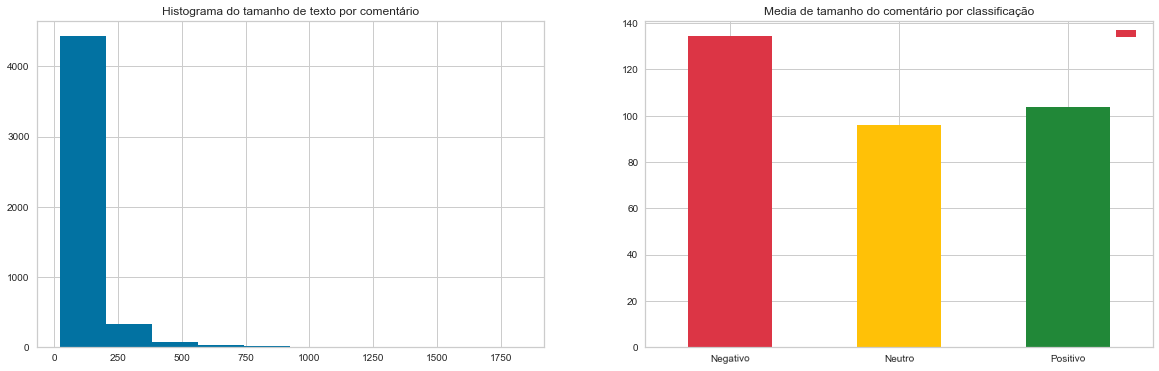

In [155]:
df["comment-len"] = df["comment"].apply(lambda x: len(x))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axes[0].set_title("Histograma do tamanho de texto por comentário")
df["comment-len"].hist(ax=axes[0], bins=10)

df_grouped = df.groupby("final_type").agg({'comment-len': 'mean'}).reset_index()
df_grouped['desc'] = ["Negativo", "Neutro", "Positivo"]
df_grouped = df_grouped.rename(df_grouped['desc'])

df_grouped.plot.bar(
        y="comment-len",
        label='',
        color=['#dc3545','#ffc107','#218838'], 
        rot=1, 
        title="Media de tamanho do comentário por classificação",
        ax=axes[1])

plt.show()

Nota-se que a maioria dos comentários se encontram entre 0 à 400 caracteres. A média de tamanho por comentário positivo, negativo ou neutro é equilibrada.

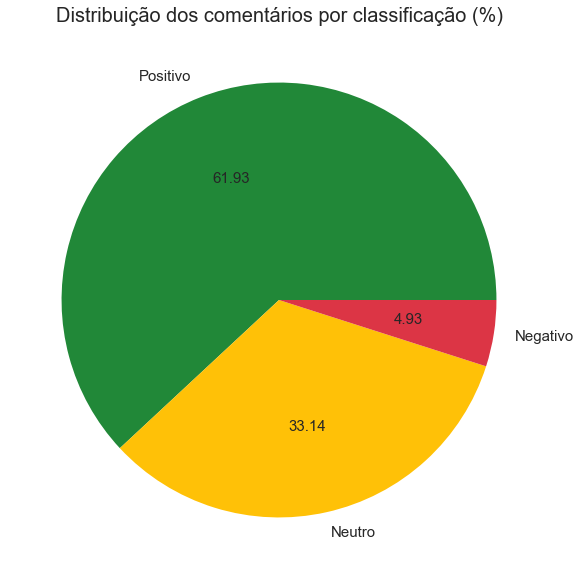

In [156]:
fig = df['final_type'].value_counts(normalize=True).plot.pie(
        autopct="%.2f",
        labels=["Positivo", "Neutro", "Negativo"],
        colors=['#218838','#ffc107','#dc3545'],
        fontsize=15,
        figsize=(10, 10),
        title="Distribuição dos comentários por classificação (%)",
        label="")

fig.axes.title.set_size(20)

Nota-se uma quantidade muito baixa de comentários negativos em nosso escopo de dados, além de uma quantidade muito grande de comentários positivos. Técnicas de balanceamento deverão ser utilizadas nesse modelo.

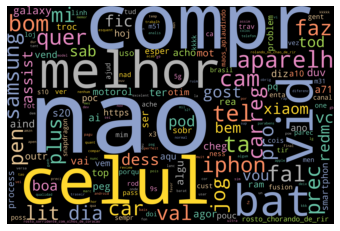

In [157]:
wc = WordCloud(background_color='black', width = 3000, height = 2000, colormap='Set2', collocations=False)
#df['transformed_comment']
wc.generate(' '.join(df['transformed_comment']))

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

# 5. Modelagem

Através da análise exploratória, entende-se que a utilização de um método de balancemento dos dados será necessário. Para isso criei uma função genérica que aplica o método oversample aos dados que serão utilizados posteriormente.

## 5.1 Imbalance Apply

In [158]:
def overSamplDef(X_res, y_res, overMethod, sampling_strategy='auto'):
    from collections import Counter
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE 
    # from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.over_sampling import KMeansSMOTE
    from imblearn.over_sampling import SVMSMOTE 
    
    # print(sampling_strategy)

    print('Before dataset shape %s' % sorted(Counter(y_res).items()))
    ros = overMethod(sampling_strategy=sampling_strategy)
    # ros = BorderlineSMOTE()
    # sampling_strategy='minority'
    # ros = SMOTE()
    X_res, y_res = ros.fit_resample(X_res, y_res)

    print('Resampled dataset shape %s' % sorted(Counter(y_res).items()))
    print("-------------------------------------------")
    return X_res, y_res

## 5.2 Criando Freatures

Por meio de alguns testes e análises efetuadas em "6.youtube-comments-types-analysis.ipynb" concluiu-se que os melhores métodos de criação de freatures a serem utilizados são o LSA e Word2Vec pois os mesmos trazem os melhores resultados quando somados ao oversample. 

In [159]:
required_columns = 'transformed_comment'
le = LabelEncoder()

X = df[required_columns]
y = le.fit_transform(df['final_type'])

### 5.2.1 Word2Vec

In [160]:
all_commnets_list = df[required_columns].to_list()

tokenized_words = []

for i in range(len(all_commnets_list)):
    #tokenize the text to list of sentences
    tokenized_sentence = nltk.sent_tokenize(all_commnets_list[i])
    #tokenize the list of sentences to list of words
    tokenized = [nltk.word_tokenize(sentence) for sentence in tokenized_sentence]
    #remove the stop words from the text
    for y, _ in enumerate(tokenized):
        tokenized_words.append([word for word in tokenized[y]])

all_commnets_list = tokenized_words

model = Word2Vec(all_commnets_list, min_count=1)

In [161]:
model.wv.save('src/eletronics_model.bin')
embeddings = KeyedVectors.load('src/eletronics_model.bin')

In [162]:
word2vec_doc_vec = pd.DataFrame()
for phrase in all_commnets_list:
  temp = pd.DataFrame()

  for word in phrase:
    try:
      word_vec = embeddings[word]
      temp = temp.append(pd.Series(word_vec), ignore_index = True)
    except:
      pass
  doc_vector = temp.mean()
  word2vec_doc_vec = word2vec_doc_vec.append(doc_vector, ignore_index = True)

word2vec_doc_vec.shape
X_w2v = word2vec_doc_vec

In [163]:
X_w2v.shape

(4907, 100)

### 5.2.2 LSA

In [164]:
# tfidf_v = TfidfVectorizer(ngram_range = (3, 3))
tfidf_v = TfidfVectorizer(ngram_range = (2, 3))
#matrixTFIDF= tfidf_v.fit_transform(train.question_text)
matrixTFIDF= tfidf_v.fit_transform(df[required_columns])
svd=TruncatedSVD(n_components=100, n_iter=20, algorithm='randomized')
X_lsa=svd.fit_transform(matrixTFIDF) 

In [165]:
X_lsa.shape

(4907, 100)

Em ambos os métodos 100 features foram criadas para a classificação dos comentários.

# 5.3 Treinando o Modelo

Para o treinamento do modelo a partir das features criadas o métodos LinearSVC trouxe o melhor resultado de recall comparado aos demais métodos utilizados em "6.youtube-comments-types-analysis.ipynb". Para a execução do oversample o método Adaptive Synthetic (ADASYN) me trouxe o melhor resultado pois o mesmo controla com melhor eficácia a replicação de outliers no meu escopo de dados em relação ao SMOTE. A estratégia utilizada para a criação de novos dados com o ADASYN foi a partir do "minority" que equilibra somente os dados de menor quantidade com os de maior quantidade, evitando qualquer alteração nos dados de categoria neutra que não são interessantes para a nossa análise. 

In [170]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ] 
svc = LinearSVC()

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, df['final_type'], test_size = .20)
X_train_w2v, y_train_w2v = overSamplDef(X_train_w2v, y_train_w2v, ADASYN, sampling_strategy='minority') #SMOTE | SMOTE
model_w2v = GridSearchCV(svc, param_grid).fit(X_train_w2v, y_train_w2v)
y_pred_w2v = model_w2v.predict(X_test_w2v)
y_pred_train_w2v = model_w2v.predict(X_train_w2v)

param_grid = [
  {'C': [1, 10, 100, 1000]}
 ] 
svc = LinearSVC()

X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, df['final_type'], test_size = .20)
X_train_lsa, y_train_lsa = overSamplDef(X_train_lsa, y_train_lsa, ADASYN, sampling_strategy='minority') #SMOTE | SMOTE
model_lsa = GridSearchCV(svc, param_grid).fit(X_train_lsa, y_train_lsa)
y_pred_lsa = model_lsa.predict(X_test_lsa)
y_pred_train_lsa = model_lsa.predict(X_train_lsa)

Before dataset shape [(-1, 184), (0, 1311), (1, 2430)]
Resampled dataset shape [(-1, 2402), (0, 1311), (1, 2430)]
-------------------------------------------
Before dataset shape [(-1, 196), (0, 1309), (1, 2420)]
Resampled dataset shape [(-1, 2406), (0, 1309), (1, 2420)]
-------------------------------------------


In [171]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("SVC - Report W2V")
print(classification_report(y_test_w2v, y_pred_w2v, target_names=target_names))

print("SVC - Report LSA")
print(classification_report(y_test_lsa, y_pred_lsa, target_names=target_names))

SVC - Report W2V
              precision    recall  f1-score   support

    Negativo       0.10      0.67      0.17        58
      Neutro       0.64      0.02      0.04       315
    Positivo       0.65      0.60      0.62       609

    accuracy                           0.42       982
   macro avg       0.46      0.43      0.28       982
weighted avg       0.61      0.42      0.41       982

SVC - Report LSA
              precision    recall  f1-score   support

    Negativo       0.07      0.83      0.13        46
      Neutro       0.56      0.06      0.11       317
    Positivo       0.66      0.42      0.52       619

    accuracy                           0.32       982
   macro avg       0.43      0.44      0.25       982
weighted avg       0.60      0.32      0.37       982



Text(0.5, 1.0, 'LSVC - LSA')

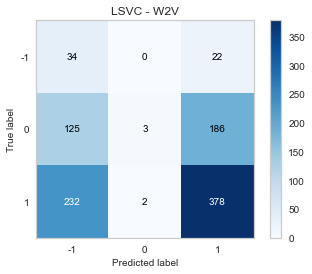

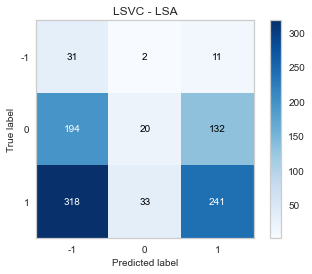

In [169]:
disp = plot_confusion_matrix(y_test_w2v, y_pred_w2v)
disp.set_title('LSVC - W2V')
disp = plot_confusion_matrix(y_test_lsa, y_pred_lsa)
disp.set_title('LSVC - LSA')

Após a execução do oversample e depois de treinar o modelo com LinearSVC obtivemos os valores de 67% de recall para negativos e 60% de recall para positivos em word2vec. Para o método LSA, obtivemos um valor mais elevado de recall em negativos (80%) e menor em positivos (35%), porém a fim de equilibrar nossos resultados em ambos os atributos, o word2vec é o mais efiente. 

# 5.3 Concretizando resultados

A fim entendermos qual é o resultado concreto do nosso modelo, efetuei o treino do modelo 600 vezes a fim de obter resultados mais precisos. 

In [ ]:
model_report = pd.DataFrame()
predict_w2v_traning = []
predict_lsa_traning = []

for exec in range(600):

    print("Execução ", exec, " de ", 600)

    param_grid = [
        {'C': [1, 10, 100, 1000]}
    ] 
    svc = LinearSVC()

    X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, df['final_type'], test_size = .2)
    X_train_w2v, y_train_w2v = overSamplDef(X_train_w2v, y_train_w2v, ADASYN, sampling_strategy='minority') #SMOTE | SMOTE
    clf = GridSearchCV(svc, param_grid).fit(X_train_w2v, y_train_w2v)
    y_pred_w2v = clf.predict(X_test_w2v)

    X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, df['final_type'], test_size = .2)
    X_train_lsa, y_train_lsa = overSamplDef(X_train_lsa, y_train_lsa, ADASYN, sampling_strategy='minority') #SMOTE | SMOTE
    clf = GridSearchCV(svc, param_grid).fit(X_train_lsa, y_train_lsa)
    y_pred_lsa = clf.predict(X_test_lsa)

    svc_w2v = classification_report(y_test_w2v, y_pred_w2v, output_dict=True)
    predict_w2v_traning.append(svc_w2v)

    svc_lsa = classification_report(y_test_lsa, y_pred_lsa, output_dict=True)
    predict_lsa_traning.append(svc_lsa)

model_w2v_report = pd.json_normalize(predict_w2v_traning)
model_lsa_report = pd.json_normalize(predict_lsa_traning)

model_w2v_report.to_csv('src/w2v_report2.csv', index=False)
model_lsa_report.to_csv('src/lsa_report2.csv', index=False)

In [172]:
model_w2v_report = pd.read_csv('src/w2v_report2.csv')
model_lsa_report = pd.read_csv('src/lsa_report2.csv')

In [173]:
model_w2v_report

,accuracy,-1.precision,-1.recall,-1.f1-score,-1.support,0.precision,0.recall,0.f1-score,0.support,1.precision,...,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,0.429162,0.087079,0.704545,0.155000,44,0.166667,0.003067,0.006024,326,0.633058,...,0.637271,597,0.295601,0.449718,0.266098,967,0.450983,0.429162,0.402518,967
1,0.450879,0.078550,0.541667,0.137203,48,0.285714,0.006536,0.012780,306,0.648649,...,0.657005,613,0.337638,0.404594,0.268996,967,0.505502,0.450879,0.427343,967
2,0.409514,0.086957,0.692308,0.154506,52,0.500000,0.023333,0.044586,300,0.654917,...,0.611785,615,0.413958,0.429875,0.270293,967,0.576314,0.409514,0.411229,967
3,0.422958,0.058496,0.583333,0.106329,36,0.333333,0.003096,0.006135,323,0.639669,...,0.638087,608,0.343833,0.407647,0.250184,967,0.515710,0.422958,0.407204,967
4,0.418821,0.065491,0.666667,0.119266,39,0.500000,0.010101,0.019802,297,0.666667,...,0.629289,631,0.410719,0.424216,0.256119,967,0.591231,0.418821,0.421524,967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.381593,0.073227,0.744186,0.133333,43,0.500000,0.006270,0.012384,319,0.636882,...,0.592396,605,0.403370,0.434725,0.246038,967,0.566662,0.381593,0.380645,967
596,0.422958,0.089286,0.673077,0.157658,52,0.500000,0.012698,0.024768,315,0.652557,...,0.634105,600,0.413948,0.434147,0.272177,967,0.572572,0.422958,0.409993,967
597,0.392968,0.064039,0.619048,0.116071,42,0.000000,0.000000,0.000000,337,0.631016,...,0.616188,588,0.231685,0.407029,0.244086,967,0.386481,0.392968,0.379724,967
598,0.407446,0.069652,0.736842,0.127273,38,0.307692,0.012945,0.024845,309,0.655797,...,0.617747,620,0.344380,0.444553,0.256622,967,0.521528,0.407446,0.409014,967


In [174]:
model_lsa_report

,accuracy,-1.precision,-1.recall,-1.f1-score,-1.support,0.precision,0.recall,0.f1-score,0.support,1.precision,...,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,0.287487,0.071918,0.823529,0.132283,51,0.456522,0.064615,0.113208,325,0.637982,...,0.463362,591,0.388807,0.417312,0.236284,967,0.547140,0.287487,0.328217,967
1,0.310238,0.063752,0.744681,0.117450,47,0.382979,0.055901,0.097561,322,0.665768,...,0.509804,598,0.370833,0.404542,0.241605,967,0.542342,0.310238,0.353462,967
2,0.298862,0.057971,0.711111,0.107203,45,0.372549,0.059375,0.102426,320,0.653846,...,0.492754,602,0.361455,0.388612,0.234127,967,0.533030,0.298862,0.345644,967
3,0.317477,0.076208,0.706897,0.137584,58,0.457143,0.049080,0.088643,326,0.634518,...,0.511771,583,0.389290,0.394931,0.245999,967,0.541233,0.317477,0.346680,967
4,0.301965,0.056239,0.800000,0.105090,40,0.490196,0.086505,0.147059,289,0.677233,...,0.477157,638,0.407890,0.418281,0.243102,967,0.595648,0.301965,0.363113,967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.338159,0.084453,0.733333,0.151463,60,0.500000,0.067114,0.118343,298,0.647783,...,0.518227,609,0.410745,0.410768,0.262678,967,0.567288,0.338159,0.372238,967
596,0.288521,0.070447,0.854167,0.130159,48,0.403846,0.064220,0.110818,327,0.651652,...,0.469189,592,0.375315,0.428314,0.236722,967,0.539004,0.288521,0.331174,967
597,0.305067,0.064171,0.765957,0.118421,47,0.442308,0.070988,0.122340,324,0.666667,...,0.496842,596,0.391048,0.410973,0.245868,967,0.562210,0.305067,0.352970,967
598,0.289555,0.053381,0.789474,0.100000,38,0.300000,0.039474,0.069767,304,0.652055,...,0.480808,625,0.335145,0.403249,0.216859,967,0.517852,0.289555,0.336623,967


In [175]:
print("Word2Vec Negative Recall ", model_w2v_report['-1.recall'].mean())
print("Word2Vec Positive Recall ", model_w2v_report['1.recall'].mean())
print("Word2Vec Negative Precision ", model_w2v_report['-1.precision'].mean())
print("Word2Vec Positive Precision ", model_w2v_report['1.precision'].mean())
print("------------------------------------------------")
print("LSA Negative Recall ", model_lsa_report['-1.recall'].mean())
print("LSA Positive Recall ", model_lsa_report['1.recall'].mean())
print("LSA Negative Precision ", model_lsa_report['-1.precision'].mean())
print("LSA Positive Precision ", model_lsa_report['1.precision'].mean())

Word2Vec Negative Recall  0.6760651665443369
Word2Vec Positive Recall  0.5902087091180059
Word2Vec Negative Precision  0.07972179854547427
Word2Vec Positive Precision  0.6387797598972071
------------------------------------------------
LSA Negative Recall  0.7701296959476054
LSA Positive Recall  0.38967991422049786
LSA Negative Precision  0.06515107584511744
LSA Positive Precision  0.6489308944833397


Para ambas as features, obtemos resultados parecidos aos executados anteriormente. Com atenção os nossos atributos principais da feature word2vec de 67% para negativos e 59% para positivos. 

<AxesSubplot:title={'center':'Histograma de precision para positivos em word2vec'}, ylabel='Frequency'>

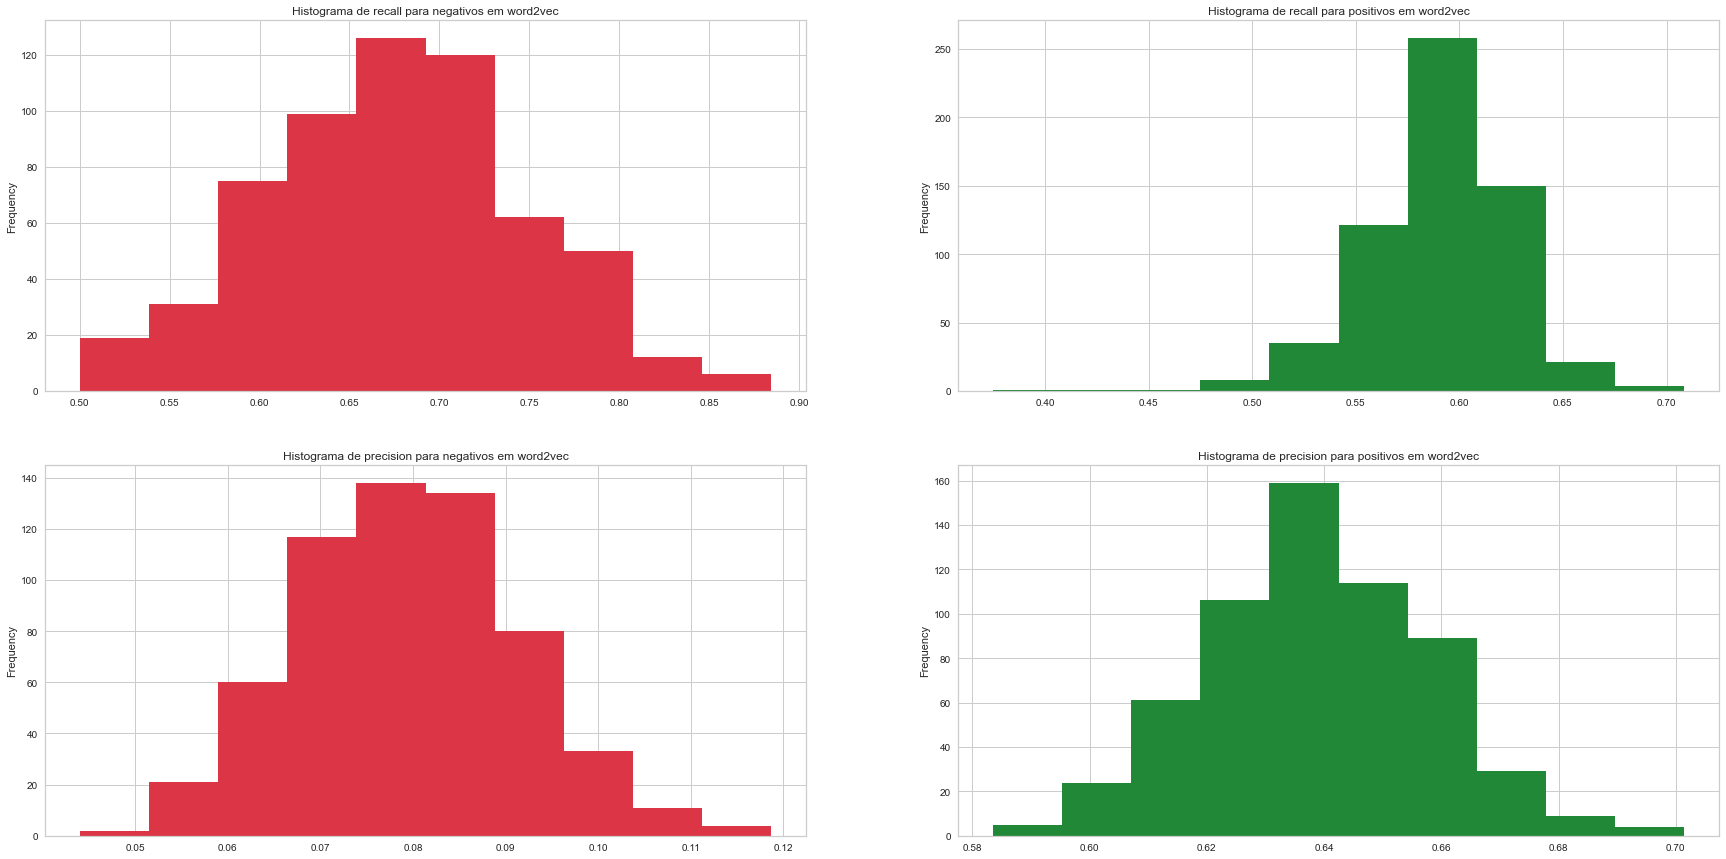

In [176]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,15))
axes[0][0].set_title("Histograma de recall para negativos em word2vec")
model_w2v_report['-1.recall'].plot.hist(ax=axes[0][0], color="#dc3545")

axes[0][1].set_title("Histograma de recall para positivos em word2vec")
model_w2v_report['1.recall'].plot.hist(ax=axes[0][1], color="#218838")

axes[1][0].set_title("Histograma de precision para negativos em word2vec")
model_w2v_report['-1.precision'].plot.hist(ax=axes[1][0], color="#dc3545")

axes[1][1].set_title("Histograma de precision para positivos em word2vec")
model_w2v_report['1.precision'].plot.hist(ax=axes[1][1], color="#218838")



In [183]:
df['transformed_comment'].iloc[0]

' porc compr faz 3 mes arrepend bug temp tod reinic volt funcion nao recom vai ser prejuiz decepca compr '